We want to have access to the Science Data Challenge data, that are stored on dCache storage that is accessible from our JupyterHub with 'ctadata' service

[<img src="platform.png" width="250"/>](image.png)


In [1]:
import ctadata
ctadata.list_dir('cta/sdc-internal-data/')

[{'href': 'cta/sdc-internal-data/',
  'mtime': 'Fri, 19 Apr 2024 08:26:06 GMT',
  'size': None,
  'type': 'directory',
  'url': 'https://platform.cta.cscs.ch/services/downloadservice/list/cta/sdc-internal-data/'},
 {'href': 'cta/sdc-internal-data/PointingPlan/',
  'mtime': 'Fri, 19 Apr 2024 08:14:52 GMT',
  'size': None,
  'type': 'directory',
  'url': 'https://platform.cta.cscs.ch/services/downloadservice/list/cta/sdc-internal-data/PointingPlan/'},
 {'href': 'cta/sdc-internal-data/products_SDC/',
  'mtime': 'Fri, 19 Apr 2024 08:14:55 GMT',
  'size': None,
  'type': 'directory',
  'url': 'https://platform.cta.cscs.ch/services/downloadservice/list/cta/sdc-internal-data/products_SDC/'},
 {'href': 'cta/sdc-internal-data/hdu-index.fits.gz',
  'mtime': 'Fri, 19 Apr 2024 08:26:05 GMT',
  'size': '163180',
  'type': 'file',
  'url': 'https://platform.cta.cscs.ch/services/downloadservice/list/cta/sdc-internal-data/hdu-index.fits.gz'},
 {'href': 'cta/sdc-internal-data/obs-index.fits.gz',
  'mti

In [2]:
from astropy.io import fits
from astropy.time import Time
from astropy.coordinates import SkyCoord,Angle

ctadata.fetch_and_save_file('cta/sdc-internal-data/obs-index.fits.gz')
ctadata.fetch_and_save_file('cta/sdc-internal-data/hdu-index.fits.gz')


163180

In Gammapy, the data and the response functions are extracted from a "data store" that needs to be initiated at the beginning of analysis:

In [3]:
import os
from gammapy.data import DataStore

GAMMAPY_DATA = os.path.join(os.getcwd(),'.') 
os.environ['GAMMAPY_DATA'] = GAMMAPY_DATA
CALDB = os.path.join(os.getcwd(),'IRFS') 
os.environ['CALDB'] = 'IRFS'
data_store=DataStore.from_dir(".")
data_store.info()

Data store:
HDU index table:
BASE_DIR: .
Rows: 36618
OBS_ID: 5000000001 -- 5000006106
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_3d', 'edisp_2d', 'events', 'gti', 'psf_3gauss']


Observation table:
Observatory name: 'N/A'
Number of observations: 6103



Similar to aperture photometry notebook, we first need to select observations doing a "simple cone search":

In [4]:
import astropy.units as u

c_s=SkyCoord.from_name("Mrk 501")
RA_s=c_s.icrs.ra.deg
DEC_s=c_s.icrs.dec.deg
selection = dict(
    type="sky_circle",
    frame="icrs",
    lon=RA_s*u.deg,
    lat=DEC_s*u.deg,
    radius="2 deg",
)

In [5]:
selected_obs_table = data_store.obs_table.select_observations(selection)
obs_ids = selected_obs_table["OBS_ID"]
observations = data_store.get_observations(obs_ids)

print(f"Number of observations in selected region: {len(selected_obs_table)}")


Number of observations in selected region: 126


We first will analyze observations pointing-by-pointing, estimating the background in each pointing and cutting large off-axis angle events (imposing a "safe mask")... We import all necessary construction.

In [6]:
from gammapy.datasets import Datasets,SpectrumDataset
from gammapy.makers import SpectrumDatasetMaker, SafeMaskMaker,ReflectedRegionsBackgroundMaker
from gammapy.maps import MapAxis, RegionGeom, WcsGeom
from regions import CircleSkyRegion


We define "true" and "reconstructed" energy axes:

In [38]:
energy_axis = MapAxis.from_energy_bounds(
    0.04, 40, nbin=10, per_decade=True, unit="TeV", name="energy"
)
energy_axis_true = MapAxis.from_energy_bounds(
    0.02, 100, nbin=20, per_decade=True, unit="TeV", name="energy_true"
)


The background will be estimated from reflected  source region of the radius "on_region_radius" with repect to the center of the pointing

In [39]:
bkg_maker = ReflectedRegionsBackgroundMaker()
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=c_s, radius=on_region_radius)
geom = RegionGeom.create(region=on_region, axes=[energy_axis])


Now we are ready to create a collection of "datasets", for analysis. These datasets are datacubes: counts in voxels with $(RA, DEC, Energy)$ coordinates. Gammapy wraps up the aperture photometry in a set of functions with sort-of self-explanatory names:

In [40]:
dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

dataset_maker = SpectrumDatasetMaker(
    containment_correction=True, selection=["counts", "exposure", "edisp"]
)

datasets = Datasets()

for obs_id, observation in zip(obs_ids, observations):
    dataset = dataset_maker.run(dataset_empty.copy(name=str(obs_id)), observation)
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    datasets.append(dataset_on_off)

info_table = datasets.info_table(cumulative=True)

display(info_table)

<Table length=126>
  name  counts       excess       ...   acceptance_off         alpha       
                                  ...                                      
  str7  int64       float64       ...      float64            float64      
------- ------ ------------------ ... ------------------ ------------------
stacked     70  65.38888549804688 ...              414.0 0.0555555559694767
stacked    136 125.05555725097656 ...  414.0000305175781 0.0555555522441864
stacked    202  185.6666717529297 ...              414.0 0.0555555559694767
stacked    270 248.27777099609375 ...  414.0000305175781 0.0555555522441864
stacked    369  342.6666564941406 ...  414.0000305175781 0.0555555522441864
stacked    455 423.77777099609375 ...  414.0000305175781 0.0555555522441864
stacked    549   512.611083984375 ...              414.0 0.0555555559694767
stacked    637              595.5 ...              414.0 0.0555555559694767
stacked    720  673.6666870117188 ...  413.9999694824219  0.055555559694767
    ...    ...                ... ...                ...                ...
stacked   9612    8988.6669921875 ... 432.00006103515625 0.0555555485188961
stacked   9712     9084.111328125 ... 432.00006103515625 0.0555555485188961
stacked   9824    9190.8330078125 ...  432.0000305175781 0.0555555522441864
stacked   9944      9305.77734375 ...  432.0000305175781 0.0555555522441864
stacked  10063     9419.388671875 ... 432.00006103515625 0.0555555485188961
stacked  10102      9454.72265625 ... 432.00006103515625 0.0555555485188961
stacked  10133     9483.111328125 ... 432.00006103515625 0.0555555485188961
stacked  10196    9540.9443359375 ...              432.0 0.0555555559694767
stacked  10247     9585.888671875 ...  432.0000305175781 0.0555555522441864
stacked  10284      9618.22265625 ... 432.00006103515625 0.0555555485188961

We can follow how signal-to-noise was accummulating with each pointing:

Text(0, 0.5, 'Sqrt(TS)')

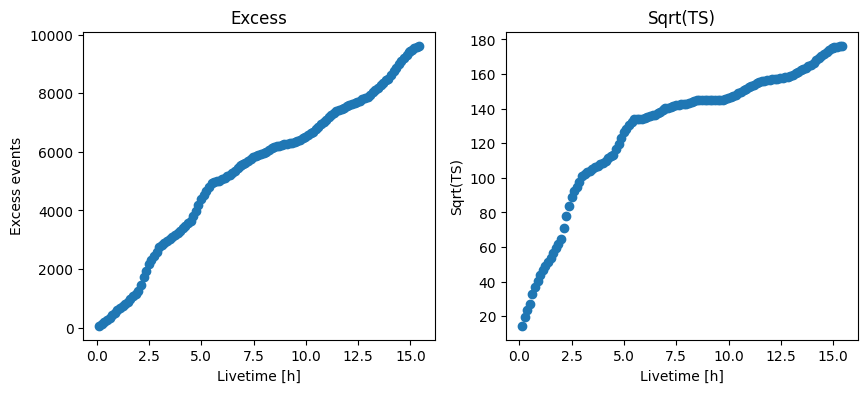

In [41]:
import matplotlib.pyplot as plt
fig, (ax_excess, ax_sqrt_ts) = plt.subplots(figsize=(10, 4), ncols=2, nrows=1)
ax_excess.plot(
    info_table["livetime"].to("h"),
    info_table["excess"],
    marker="o",
    ls="none",
)

ax_excess.set_title("Excess")
ax_excess.set_xlabel("Livetime [h]")
ax_excess.set_ylabel("Excess events")

ax_sqrt_ts.plot(
    info_table["livetime"].to("h"),
    info_table["sqrt_ts"],
    marker="o",
    ls="none",
)

ax_sqrt_ts.set_title("Sqrt(TS)")
ax_sqrt_ts.set_xlabel("Livetime [h]")
ax_sqrt_ts.set_ylabel("Sqrt(TS)")

The fitting part of the aperture photometry method is also wrapped into functions associated to the datasets:

In [42]:
from gammapy.modeling.models import ExpCutoffPowerLawSpectralModel, SkyModel
from gammapy.modeling import Fit

spectral_model = ExpCutoffPowerLawSpectralModel(
    amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"),
    index=2,
    lambda_=0.1 * u.Unit("TeV-1"),
    reference=1 * u.TeV,
)
model = SkyModel(spectral_model=spectral_model, name="Mrk501")

datasets.models = [model]

fit_joint = Fit()

# we make a copy here to compare it later
model_best_joint = model.copy()
result_joint = fit_joint.run(datasets=datasets)
print(result_joint)
tab=result_joint.models.to_parameters_table()
display(tab)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 206
	total stat : 5095.66

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



<Table length=5>
model  type    name     value         unit      ... frozen is_norm link prior
 str6  str1    str9    float64       str14      ...  bool    bool  str1  str1
------ ---- --------- ---------- -------------- ... ------ ------- ---- -----
Mrk501          index 2.1324e+00                ...  False   False           
Mrk501      amplitude 1.2770e-11 TeV-1 s-1 cm-2 ...  False    True           
Mrk501      reference 1.0000e+00            TeV ...   True   False           
Mrk501        lambda_ 2.1591e-01          TeV-1 ...  False   False           
Mrk501          alpha 1.0000e+00                ...   True   False

In [43]:
Gam_best=tab['value'][0]
Gam_err=tab['error'][0]
Norm_best=tab['value'][1]
Norm_err=tab['error'][1]
Ecut_best=1./tab['value'][3]
Ecut_err=tab['error'][3]/tab['value'][3]**2
print(Gam_best,Gam_err)
print(Norm_best,Norm_err)
print(Ecut_best,Ecut_err)

2.1323945186803863 0.022993430657697343
1.2770249336098868e-11 3.682126655671154e-13
4.63153263960728 0.36329006855333934


Now we have the fitted spectral model, which we can already plot as a curve:

Text(0, 0.5, '$E^2 dN/dE$, TeV/cm$^2$s')

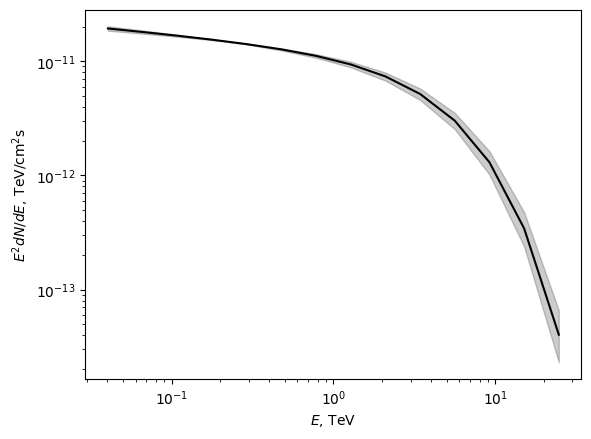

In [44]:
import numpy as np
from numpy import sqrt,exp
energy_edges = np.logspace(-1.5, 1.5, 15)
energy_mean=sqrt(energy_edges[1:]*energy_edges[:-1])
y=Norm_best*(energy_mean/1.)**(2-Gam_best)*exp(-(energy_mean/Ecut_best))
y1=(Norm_best-Norm_err)*(energy_mean/1.)**(2-(Gam_best+Gam_err))*exp(-(energy_mean/(Ecut_best-Ecut_err)))
y2=(Norm_best+Norm_err)*(energy_mean/1.)**(2-(Gam_best-Gam_err))*exp(-(energy_mean/(Ecut_best+Ecut_err)))
plt.plot(energy_mean,y,color='black')
plt.fill_between(energy_mean,y1,y2,alpha=0.2,color='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$E$, TeV')
plt.ylabel('$E^2 dN/dE$, TeV/cm$^2$s')

We also want to see the flux points in narrow energy bins (this step takes long time, about 10 min or so)


In [45]:
from gammapy.estimators import FluxPointsEstimator

energy_edges = energy_edges * u.TeV

fpe = FluxPointsEstimator(
    energy_edges=energy_edges, source="Mrk501", selection_optional="all"
)
flux_points = fpe.run(datasets=datasets)

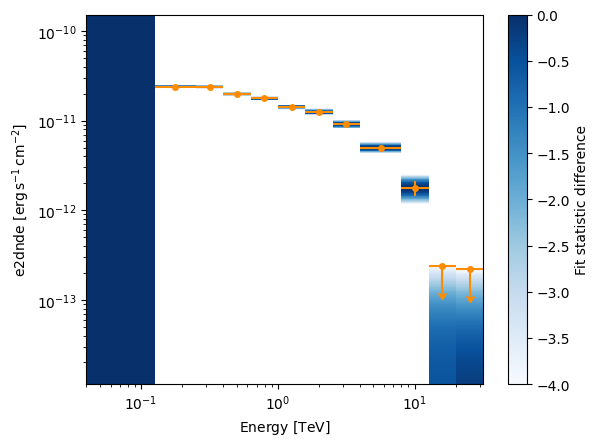

In [46]:
fig, ax = plt.subplots()
flux_points.plot(ax=ax, sed_type="e2dnde", color="darkorange")
flux_points.plot_ts_profiles(ax=ax, sed_type="e2dnde")
plt.show()

Just in case, here is a comparison of the "simple flux" estimate and output of Gammapy analysis:

[<img src="Aperture_gammapy_comparison.png" width="750"/>](image.png)